# 检索增强生成（Retrieval Augmented Generation, RAG）第 2 部分：  
> 构建一个结合用户交互记忆和多步骤检索的 RAG 应用程序。

### 构建一个检索增强生成（RAG）应用程序：第 2 部分

在许多问答（Q&A）应用中，我们希望用户能够进行**来回对话**。这意味着应用程序需要具备某种形式的“记忆”功能，记录过去的提问与回答，并将这些信息纳入当前的思考逻辑中。

这是本系列教程的第二部分：

- **第 1 部分**：介绍了 RAG 的基本概念，并演示了一个最小可行实现。
- **第 2 部分（本指南）**：扩展了该实现，使其支持**对话式交互**和**多步骤检索流程**。

在本部分中，我们将重点介绍如何加入**历史消息处理逻辑**，即管理聊天记录（chat history）。

---

我们将介绍两种主要实现方式：

#### 1. 使用 Chains（链式调用）
在这种方法中，最多只执行一次检索操作。它适用于结构较为固定的流程。

#### 2. 使用 Agents（智能体）
这种方法赋予语言模型（LLM）更大的自主权，使其可以根据需要执行**多个检索步骤**，从而更灵活地处理复杂问题。

> 💡 **注意**：  
本节所使用的方法依赖于现代聊天模型中的 **工具调用（tool calling）** 功能。  

---

### 数据源说明

为了提供外部知识支持，我们将继续使用第 1 部分中使用的那篇博客文章 —— [**中小企业出海对接交流会**](https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html)。

### 我们首先回顾一下在第 1 部分中构建的向量数据库（vector store）。

In [1]:
import getpass
import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv

    _ = load_dotenv()
except ImportError:
    pass

if not os.environ.get("DASHSCOPE_API_KEY"):
  os.environ["DASHSCOPE_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [2]:
from langchain_community.chat_models.tongyi import ChatTongyi

llm  = ChatTongyi(
    streaming=True,
    name="qwen-turbo"
)

In [3]:
from langchain_community.embeddings.dashscope import DashScopeEmbeddings
# 初始化 Qwen Embedding 模型
embeddings = DashScopeEmbeddings(model="text-embedding-v1")  

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("view-wrap")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

在 RAG 教程的第 1 部分中，我们将用户输入、检索到的上下文以及生成的回答分别作为状态中的独立键来表示。

而在对话式应用场景中，使用**消息序列（sequence of messages）** 可以更自然地表达交互过程。除了用户的输入（User）和助手的回复（Assistant）之外，检索到的文档和其他中间结果也可以通过 **工具消息（ToolMessage）** 的形式插入到消息序列中。

这促使我们使用一个**消息序列**来表示 RAG 应用的状态。具体来说，我们的消息结构将包括：

- 用户输入：`HumanMessage`
- 向量数据库查询：带有工具调用的 `AIMessage`
- 检索到的文档：`ToolMessage`
- 最终回复：`AIMessage`

这种状态表示方式非常灵活，因此 LangGraph 提供了一个**内置版本**来简化这一流程，方便开发者直接使用。

In [7]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

利用**工具调用（tool-calling）** 来与检索步骤进行交互还有一个额外的好处：即检索所使用的查询是由我们的语言模型生成的。这一点在**对话式场景**中尤为重要，因为用户的提问可能需要根据聊天历史进行上下文化理解（contextualization）。例如，考虑以下对话：

---

**用户**： “什么是任务分解（Task Decomposition）？”

**AI**： “任务分解是指将复杂的任务拆分成更小、更简单的步骤，从而使智能体或模型更容易处理。”

**用户**： “常见的实现方式有哪些？”

---

在这种情况下，模型可以自动生成一个检索查询，例如 `"common approaches to task decomposition"`（任务分解的常见方法）。而 **工具调用机制** 可以非常自然地支持这一行为。

正如在 RAG 教程的“查询分析”部分所提到的那样，这种方式允许模型将用户的原始问题重写为更高效的搜索查询。同时，它也支持**无需检索步骤的直接回答**（例如，当用户发送的是通用问候语时）。

---

### 现在，让我们将检索步骤封装为一个工具：

In [8]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

我们的图（Graph）将包含三个节点：

1. **处理用户输入的节点**：该节点会分析用户的提问，决定是为检索器生成一个查询语句，还是直接做出回应；
2. **检索工具节点**：该节点负责执行实际的检索步骤；
3. **生成最终回答的节点**：使用检索到的上下文信息，生成最终的自然语言回复。

我们将在下方构建这三个节点。请注意，我们会使用 LangGraph 提供的另一个预构建组件 **`ToolNode`**，它能够自动执行工具调用，并将结果作为 `ToolMessage` 添加到当前的状态（State）中。

In [9]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

最后，我们将整个应用程序编译成一个**图对象（graph object）**。在本例中，我们只是将各个步骤按顺序连接起来形成一个流程。

此外，我们还允许第一个步骤 `query_or_respond`（查询或回应）进行“短路”处理 —— 也就是说，如果它**没有生成工具调用（tool call）**，就可以直接向用户返回响应。

这种设计使我们的应用程序能够更好地支持**对话式交互体验**，例如：  
- 对不需要检索步骤的通用问候语（如“你好”、“谢谢”）做出直接回应；
- 根据上下文判断是否需要执行检索，提升交互的灵活性和自然性。

In [10]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

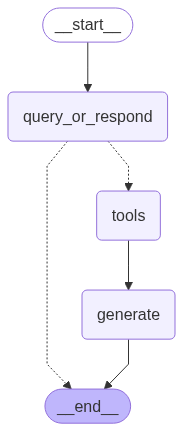

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
input_message = "你好"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

你好
================================== Ai Message ==================================

你好！有什么我可以帮助你的？


In [13]:
input_message = "有多少家企业参加活动?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

有多少家企业参加活动?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_8dd0ac83ac544e6cb7261acall_8dd0ac83ac544e6cb7261acall_8dd0ac83ac544e6cb7261acall_8dd0ac83ac544e6cb7261a)
 Call ID: call_8dd0ac83ac544e6cb7261acall_8dd0ac83ac544e6cb7261acall_8dd0ac83ac544e6cb7261acall_8dd0ac83ac544e6cb7261a
  Args:
    query: 参加活动的企业数量
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html'}
Content: 来源：
          天津市工业和信息化局
        
发布时间：
          2025-04-08 09:30
        


为深入贯彻党的二十届三中全会精神，落实《工业和信息化部办公厅关于开展中小企业出海服务专项行动的通知》及《工业和信息化部等17部门办公厅（室）关于开展2025年“一起益企”中小企业服务行动的通知》要求，进一步提升我市中小企业国际化水平和核心竞争力，助力中小企业开拓国际市场、增强风险防控能力，天津市中小企业服务中心于近日成功举办轻工产业链中小企业出海对接交流会。中国中小企业发展促进中心、天津市贸促会、天津市食品工业协会、天津市自行车电动车行业协会、武清区崔黄口镇商会，以及来自自行车、食品、地毯等领域的生产制造企业和进出口企

### 聊天历史的状态化管理（Stateful Management of Chat History）



### 在生产环境中

在一个问答（Q&A）应用程序中，通常需要将聊天历史**持久化到数据库中**，并能够在后续交互中正确地读取和更新它。

**LangGraph 提供了一个内置的持久化层（persistence layer）**，这使得它非常适合用于支持多轮对话的聊天应用。

---

### 如何实现？

要支持多个对话轮次（turns）或多条对话线程（threads），我们只需在编译应用程序时指定一个 **checkpointer（检查点器）**。由于我们图中的各个节点都在向状态（state）中追加消息，因此我们可以在多次调用之间保留一致的聊天历史记录。

LangGraph 自带了一个简单的**内存型 checkpointer**，我们在下面的示例中使用它。你也可以参考其[官方文档](https://example.com/checkpointer-docs)，了解更多关于使用其他持久化后端（如 SQLite 或 PostgreSQL）的方法。

---

### 示例代码（使用内存型 Checkpointer）

```python
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph

# 创建一个内存保存器
checkpointer = MemorySaver()

# 编译图并启用持久化
app = graph.compile(checkpointer=checkpointer)
```

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [15]:
input_message = "文章发布的时间?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

文章发布的时间?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_7d018350d2144375952f55call_7d018350d2144375952f55call_7d018350d2144375952f55call_7d018350d2144375952f55)
 Call ID: call_7d018350d2144375952f55call_7d018350d2144375952f55call_7d018350d2144375952f55call_7d018350d2144375952f55
  Args:
    query: 发布日期
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html'}
Content: 工信动态
          





        天津市中小企业服务中心成功举办轻工 产业链中小企业出海对接交流会
      

来源：
          天津市工业和信息化局
        
发布时间：
          2025-04-08 09:30

Source: {'source': 'https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html'}
Content: 来源：
          天津市工业和信息化局
        
发布时间：
          2025-04-08 09:30
        


为深入贯彻党的二十届三中全会精神，落实《工业和信息化

In [16]:
input_message = "“走出去”的口号是什么意思?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

“走出去”的口号是什么意思?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_49e867ccad2d4e2f8a2144call_49e867ccad2d4e2f8a2144call_49e867ccad2d4e2f8a2144call_49e867ccad2d4e2f8a2144)
 Call ID: call_49e867ccad2d4e2f8a2144call_49e867ccad2d4e2f8a2144call_49e867ccad2d4e2f8a2144call_49e867ccad2d4e2f8a2144
  Args:
    query: 走出去的含义
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html'}
Content: 来源：
          天津市工业和信息化局
        
发布时间：
          2025-04-08 09:30
        


为深入贯彻党的二十届三中全会精神，落实《工业和信息化部办公厅关于开展中小企业出海服务专项行动的通知》及《工业和信息化部等17部门办公厅（室）关于开展2025年“一起益企”中小企业服务行动的通知》要求，进一步提升我市中小企业国际化水平和核心竞争力，助力中小企业开拓国际市场、增强风险防控能力，天津市中小企业服务中心于近日成功举办轻工产业链中小企业出海对接交流会。中国中小企业发展促进中心、天津市贸促会、天津市食品工业协会、天津市自行车电动车行业协会、武清区崔黄口镇商会，以及来自自行车、食品、地毯等领域的生产制造企业和进出口企

In [17]:
input_message = "是星期几呢?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

是星期几呢?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726c)
 Call ID: call_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726ccall_d7193225ab704fa0b1726c
  Args:
    query: 2025年4月8日是星期几
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html'}
Content: 来源：
          天津市工业和信息化局
        
发布时间：
          2025-04-08 09:30
        


为深入贯彻党的二十届三中全会精神，落实《工业和信息化部办公厅关于开展中小企业出海服务专项行动的通知》及《工业和信息化部等17部门办公厅（室）关于开展2025年“一起益企”中小企业服务行动的通知》要求，进一步提升我市中小企业国际化水平和核心竞争力，助力中小企业开拓国际市场、增强风险防控能力，天津市中小企业服务中

> 请注意，问题中模型生成的查询包含了对话上下文。

### 智能体（Agents）

**智能体（Agents）** 利用大语言模型（LLMs）的推理能力，在执行过程中进行决策。使用智能体可以让你在检索流程中拥有更多的自主判断空间。

虽然相比前面提到的“链式调用（chain）”方式，智能体的行为更具不确定性、更难预测，但它们能够在处理一个查询时：

- 执行**多个检索步骤**；
- 或者对一次检索结果进行**迭代优化**。

---

### 构建一个最简 RAG 智能体

下面我们构建一个最小的 RAG 智能体。借助 LangGraph 提供的预构建 **ReAct 智能体构造器（agent constructor）**，我们只需一行代码即可完成创建：



In [18]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

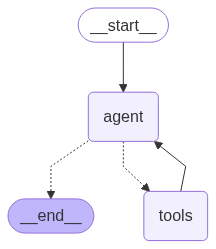

In [19]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

与我们之前实现的最大区别在于：  
以前的流程中，最后一步是生成答案并结束整个流程；而在智能体（Agent）模式中，**工具调用会回传给原始的语言模型调用**，形成一个循环。

这样一来，模型可以根据检索到的信息：

- 直接回答用户的问题；
- 或者再次生成一个新的工具调用，以获取更多信息。

这种机制使得模型能够在需要时进行多轮检索，从而逐步逼近最终答案。

---

### 我们来测试一下这个功能

我们可以构造一个通常需要**多次检索步骤**才能回答的问题。例如：

> “这是星期几发布的？”

这个问题包含多个层次。



In [20]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "这是星期几发布的？\n\n"
    "得到答案后，查找该方法的常见扩展。"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

这是星期几发布的？

得到答案后，查找该方法的常见扩展。
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_77ef58d390ee4b1b8454f6call_77ef58d390ee4b1b8454f6call_77ef58d390ee4b1b8454f6call_77ef58d390ee4b1b8454f6)
 Call ID: call_77ef58d390ee4b1b8454f6call_77ef58d390ee4b1b8454f6call_77ef58d390ee4b1b8454f6call_77ef58d390ee4b1b8454f6
  Args:
    query: 发布日期 星期几
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html'}
Content: 工信动态
          





        天津市中小企业服务中心成功举办轻工 产业链中小企业出海对接交流会
      

来源：
          天津市工业和信息化局
        
发布时间：
          2025-04-08 09:30

Source: {'source': 'https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202504/t20250408_6902492.html'}
Content: 来源：
          天津市工业和信息化局
        
发布时间：
          2025-04-08 09:30
        


为深

### 请注意，智能体（Agent）的执行过程如下：

1. **生成一个查询**，用于搜索任务分解的标准方法；
2. 在**收到第一轮检索结果后**，生成**第二个查询**，用于搜索该方法的常见扩展或补充内容；
3. 在**获取到所有必要的上下文信息后**，最终生成对用户问题的完整回答。

这种多步骤、自动化的检索流程使得智能体能够更深入地理解并回答复杂问题。